## Plot Benchmark Results for Reading MMTF Hadoop Sequence Files
Reading the entire [Protein Data Bank (PDB)](https://www.wwpdb.org/) from an [MMTF Hadoop Sequence File](https://mmtf.rcsb.org/download.html) involves the following steps:
1. **read** raw MMTF Hadoop Sequence File consisting of key/value pairs (PDBId/PDB data in MMTF format)
2. **unzip** the values
3. **unpack** the msgpack-encoded values (using pandas and msgpack libraries for comparison)
4. **decode** the MMTF data structure

Since Apache Spark use a directed acyclic graph (DAG) scheduler to execute steps, we cannot directly monitor the times required for each step. We infer the effective time for each step by subtracting the time from a previous step run independently.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
r = pd.read_csv('../results/read.csv')[['cores','read']]
p = pd.read_csv('../results/unpack_pd.csv')[['cores','unpack_pd']]
z = pd.read_csv('../results/unzip.csv')[['cores','unzip']]
h = pd.read_csv('../results/read_hadoop.csv')[['cores','read_hadoop']]

In [3]:
data = r.merge(p, on='cores')
data = data.merge(z, on='cores')
data = data.merge(h, on='cores')
data = data.sort_values('cores')

In [4]:
data = data.rename(index=str, columns={'read': 'read_unzip_unpack_decode'})
data = data.rename(index=str, columns={'unpack_pd': 'read_unzip_unpack'})
data = data.rename(index=str, columns={'unzip': 'read_unzip'})
data = data.rename(index=str, columns={'read_hadoop': 'read'})

In [5]:
n_cores = data.cores.max()
print("Max number of cores:", n_cores)

Max number of cores: 4


In [6]:
df = data.copy()
df

,cores,read_unzip_unpack_decode,read_unzip_unpack,read_unzip,read
2,1,433.299615,226.785902,167.669005,107.548515
1,2,280.955425,146.084556,110.188728,73.148682
0,4,252.546578,129.771995,100.053072,68.628744


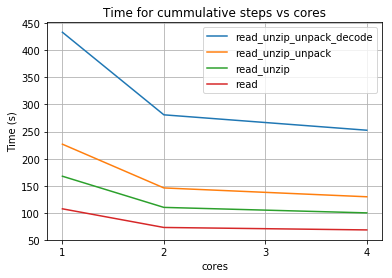

In [7]:
df.plot.line(x="cores", grid=True, title="Time for cummulative steps vs cores")

plt.ylabel('Time (s)')
plt.xticks(np.arange(1, n_cores+1, 1))
plt.savefig('../results/ReadCummulativeSteps_TimeVsCores.png')
plt.show()

## Calculate Speedup

In [8]:
df['read_unzip_unpack_decode'] = df.read_unzip_unpack_decode.max()/df.read_unzip_unpack_decode
df['read_unzip_unpack'] = df.read_unzip_unpack.max()/df.read_unzip_unpack
df['read_unzip'] = df.read_unzip.max()/df.read_unzip
df['read'] = df.read.max()/df.read
df

,cores,read_unzip_unpack_decode,read_unzip_unpack,read_unzip,read
2,1,1.000000,1.000000,1.000000,1.000000
1,2,1.542236,1.552429,1.521653,1.470273
0,4,1.715722,1.747572,1.675801,1.567106


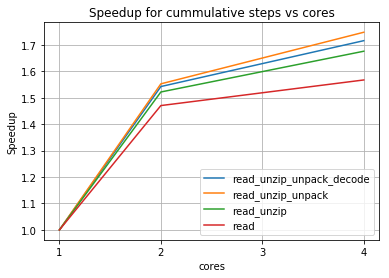

In [9]:
df.plot.line(x="cores", grid=True, title="Speedup for cummulative steps vs cores")

plt.ylabel('Speedup')
plt.xticks(np.arange(1, n_cores+1, 1))
plt.savefig('../results/ReadCummulativeSteps_SpeedupVsCores.png')
plt.show()

## Calculate Times for individual steps

In [10]:
df = data.copy()
df['decode'] = df.read_unzip_unpack_decode - df.read_unzip_unpack
df['unpack'] = df.read_unzip_unpack - df.read_unzip
df['unzip'] = df.read_unzip - df.read
df

,cores,read_unzip_unpack_decode,read_unzip_unpack,read_unzip,read,decode,unpack,unzip
2,1,433.299615,226.785902,167.669005,107.548515,206.513713,59.116897,60.120490
1,2,280.955425,146.084556,110.188728,73.148682,134.870869,35.895828,37.040046
0,4,252.546578,129.771995,100.053072,68.628744,122.774583,29.718923,31.424328


In [11]:
df = df[['cores','decode','unpack','unzip','read']].copy()

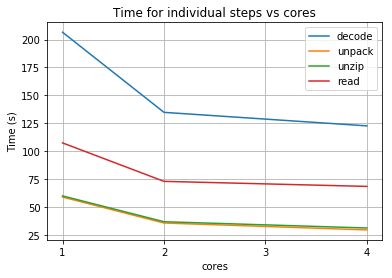

In [12]:
df.plot.line(x="cores", grid=True, title="Time for individual steps vs cores")

plt.ylabel('Time (s)')
plt.xticks(np.arange(1, n_cores+1, 1))
plt.savefig('../results/ReadIndividualSteps_TimeVsCores.png')
plt.show()

## Calculate Speedup for individual steps

In [13]:
df['decode'] = df.decode.max()/df.decode
df['unpack'] = df.unpack.max()/df.unpack
df['unzip'] = df.unzip.max()/df.unzip
df['read'] = df.read.max()/df.read
df

,cores,decode,unpack,unzip,read
2,1,1.000000,1.000000,1.000000,1.000000
1,2,1.531196,1.646902,1.623121,1.470273
0,4,1.682056,1.989201,1.913183,1.567106


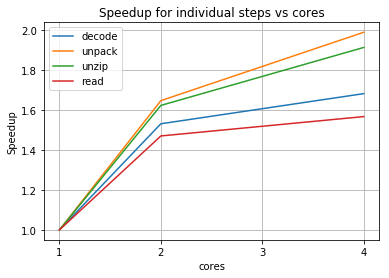

In [14]:
df.plot.line(x="cores", grid=True, title="Speedup for individual steps vs cores")

plt.ylabel('Speedup')
plt.xticks(np.arange(1, n_cores+1, 1))
plt.savefig('../results/ReadIndividualSteps_SpeedupVsCores.png')
plt.show()

## Compare two libraries for decoding msgpacked data
1. msgpack
2. pandas

In [15]:
m = pd.read_csv('../results/unpack_msgpack.csv')[['cores','unpack_msgpack']]
p = pd.read_csv('../results/unpack_pd.csv')[['cores','unpack_pd']]
z = pd.read_csv('../results/unzip.csv')[['cores','unzip']]
data = m.merge(p, on='cores')
data = data.merge(z, on='cores')
data = data.sort_values('cores')

In [16]:
data = data.rename(index=str, columns={'unpack_msgpack': 'read_unzip_unpack_msgpack'})
data = data.rename(index=str, columns={'unpack_pd': 'read_unzip_unpack_pandas'})
data = data.rename(index=str, columns={'unzip': 'read_unzip'})

In [17]:
df = data.copy()
df

,cores,read_unzip_unpack_msgpack,read_unzip_unpack_pandas,read_unzip
2,1,777.912697,226.785902,167.669005
1,2,439.496938,146.084556,110.188728
0,4,439.697267,129.771995,100.053072


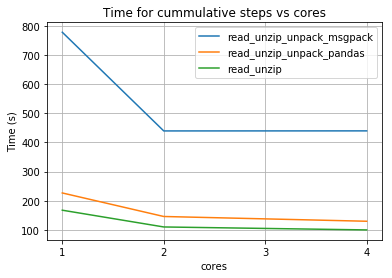

In [18]:
df.plot.line(x="cores", grid=True, title="Time for cummulative steps vs cores")

plt.ylabel('Time (s)')
plt.xticks(np.arange(1, n_cores+1, 1))
plt.savefig('../results/ReadCummulativeSteps_MsgPack_TimeVsCores.png')
plt.show()

In [19]:
df = data.copy()
df['unpack_msgpack'] = df.read_unzip_unpack_msgpack - df.read_unzip
df['unpack_pandas'] = df.read_unzip_unpack_pandas - df.read_unzip
df = df[['cores','unpack_msgpack','unpack_pandas']]
df

,cores,unpack_msgpack,unpack_pandas
2,1,610.243692,59.116897
1,2,329.308210,35.895828
0,4,339.644195,29.718923


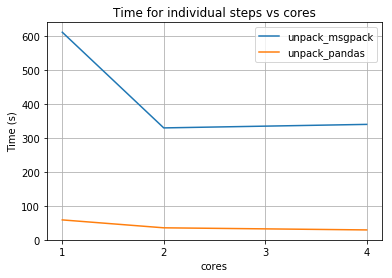

In [20]:
df.plot.line(x="cores", grid=True, title="Time for individual steps vs cores")

plt.ylabel('Time (s)')
plt.xticks(np.arange(1, n_cores+1, 1))
plt.savefig('../results/ReadIndividualSteps_MsgPack_TimeVsCores..png')
plt.show()